# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/scratch/yns207/data_facegen'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

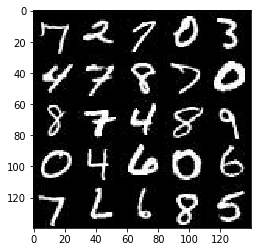

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

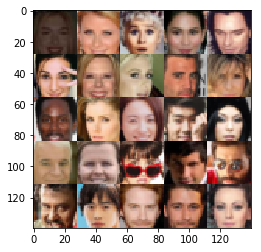

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_img = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_data = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)
    
    return real_img, z_data, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d(x, 512, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        
        tensor_logits = tf.layers.dense(tf.reshape(x, [-1,4*4*256]), 1)
        tensor_out = tf.nn.sigmoid(tensor_logits)

        return tensor_out, tensor_logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, [-1,7,7,256])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha,x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha,x)
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
                
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
        return tf.tanh(logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=0.2)
    d_model_real_out, d_model_real_logits = discriminator(input_real, reuse=False, alpha=0.2)
    d_model_fake_out, d_model_fake_logits = discriminator(g_model, reuse=True, alpha=0.2)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_model_real_logits,
            labels=tf.ones_like(d_model_real_logits)*(0.9)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_model_fake_logits,
            labels=tf.zeros_like(d_model_fake_logits)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_model_fake_logits,
            labels=tf.ones_like(d_model_fake_logits)
        )
    )    
    
    return d_loss_fake+d_loss_real, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    all_vars = tf.trainable_variables()
    g_vars = [v for v in all_vars if 'generator' in v.name]
    d_vars = [v for v in all_vars if 'discriminator' in v.name]
    
    for var in all_vars:
        assert var in g_vars or var in d_vars
        
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    steps = 0
    real_img, z_data, learn_rate = model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_img, z_data, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for b,batch_images in enumerate(get_batches(batch_size)):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1,1,size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_img:batch_images, z_data:batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={real_img:batch_images, z_data:batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={real_img:batch_images, z_data:batch_z, learn_rate:learning_rate})

                if steps % 256 == 0:
                    train_loss_d = d_loss.eval({z_data:batch_z,real_img:batch_images})
                    train_loss_g = g_loss.eval({z_data:batch_z})
                    
                    print('batch {}'.format(b),
                          'discriminator loss: {:.4f}'.format(train_loss_d),
                          'generator loss: {:.4f}'.format(train_loss_g)
                         )
                    show_generator_output(sess, 16, z_data, data_shape[3], data_image_mode)
            show_generator_output(sess, 16, z_data, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [12]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13886288312870672937, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 384565248
 locality {
   bus_id: 2
 }
 incarnation: 4193097872413462009
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:84:00.0"]

batch 255 discriminator loss: 1.6675 generator loss: 0.4935


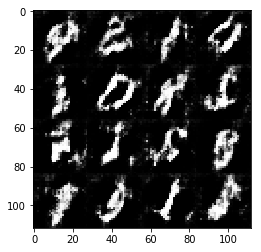

batch 511 discriminator loss: 1.4473 generator loss: 0.5322


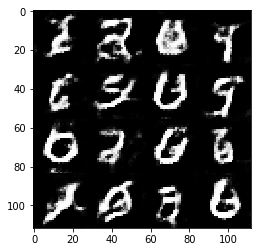

batch 767 discriminator loss: 1.9539 generator loss: 0.2625


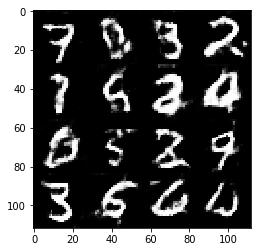

batch 1023 discriminator loss: 1.8534 generator loss: 0.2735


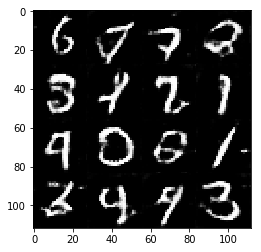

batch 1279 discriminator loss: 1.6105 generator loss: 0.3724


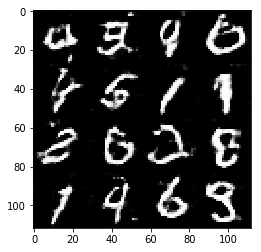

batch 1535 discriminator loss: 2.6606 generator loss: 0.1220


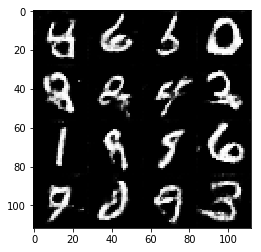

batch 1791 discriminator loss: 3.1310 generator loss: 0.0884


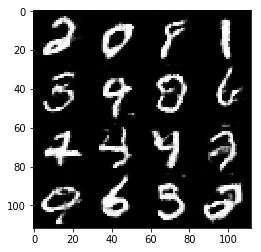

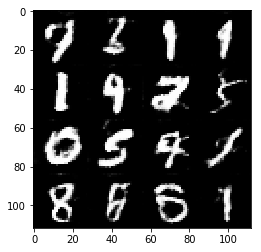

batch 172 discriminator loss: 2.1570 generator loss: 0.2062


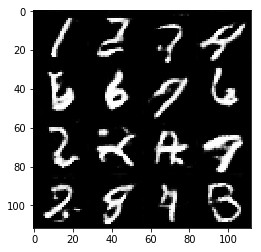

batch 428 discriminator loss: 2.0185 generator loss: 0.2281


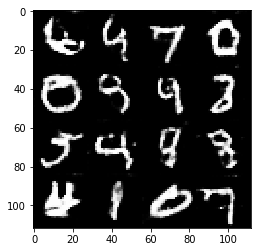

batch 684 discriminator loss: 1.3366 generator loss: 0.5021


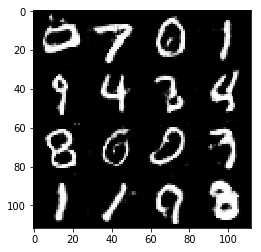

batch 940 discriminator loss: 2.1830 generator loss: 0.2068


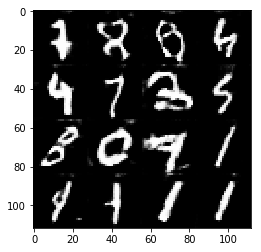

batch 1196 discriminator loss: 3.3574 generator loss: 0.0961


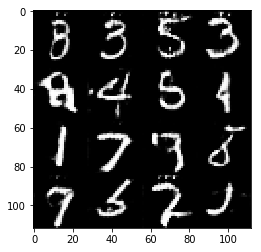

batch 1452 discriminator loss: 1.2605 generator loss: 0.7818


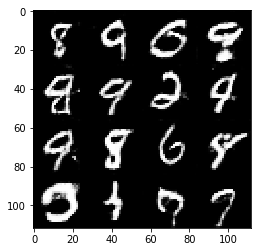

batch 1708 discriminator loss: 2.0903 generator loss: 0.2234


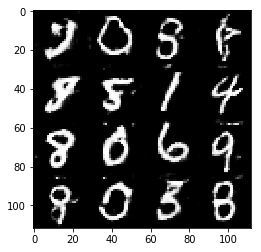

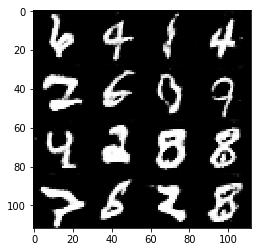

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.45

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

batch 255 discriminator loss: 1.4725 generator loss: 0.6337


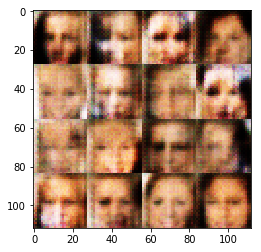

batch 511 discriminator loss: 1.3850 generator loss: 0.7868


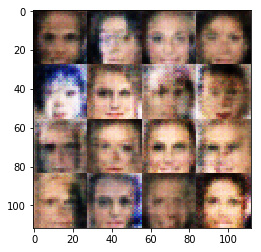

batch 767 discriminator loss: 1.5656 generator loss: 0.5572


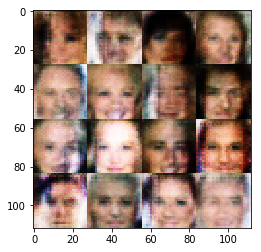

batch 1023 discriminator loss: 1.7170 generator loss: 0.6532


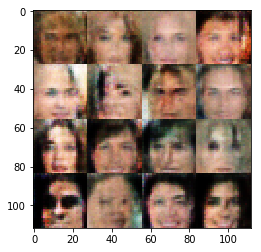

batch 1279 discriminator loss: 1.6307 generator loss: 0.4125


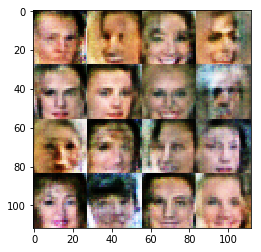

batch 1535 discriminator loss: 1.7406 generator loss: 0.5643


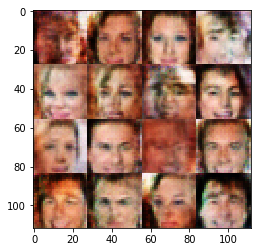

batch 1791 discriminator loss: 1.5344 generator loss: 0.4042


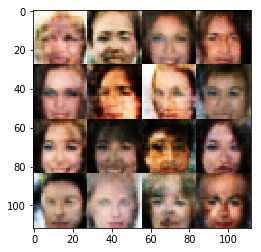

batch 2047 discriminator loss: 1.5386 generator loss: 0.5252


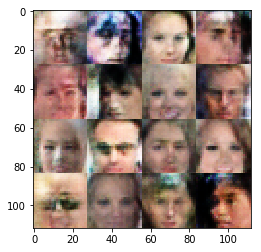

batch 2303 discriminator loss: 1.5842 generator loss: 0.5271


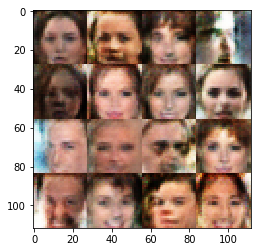

batch 2559 discriminator loss: 1.4892 generator loss: 0.5987


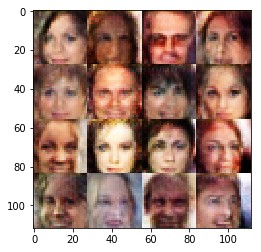

batch 2815 discriminator loss: 1.4522 generator loss: 0.5488


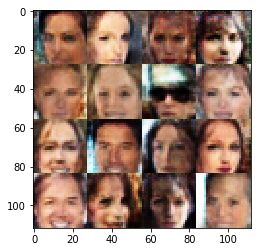

batch 3071 discriminator loss: 1.6462 generator loss: 0.4311


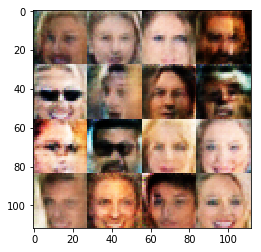

batch 3327 discriminator loss: 1.7362 generator loss: 0.4217


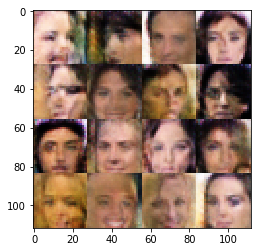

batch 3583 discriminator loss: 1.7232 generator loss: 0.4102


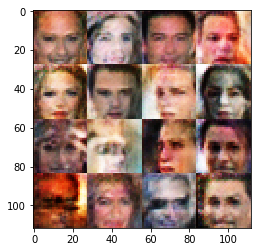

batch 3839 discriminator loss: 1.5298 generator loss: 0.5170


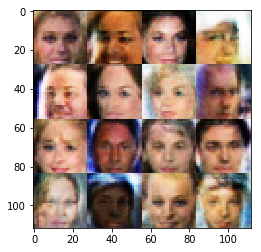

batch 4095 discriminator loss: 1.6991 generator loss: 0.4980


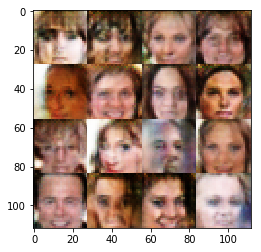

batch 4351 discriminator loss: 1.3863 generator loss: 0.6904


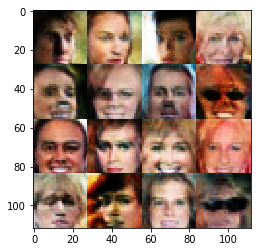

batch 4607 discriminator loss: 1.5770 generator loss: 0.5710


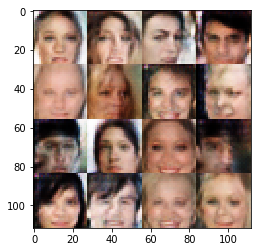

batch 4863 discriminator loss: 1.6319 generator loss: 0.3880


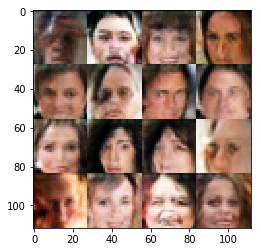

batch 5119 discriminator loss: 1.5074 generator loss: 0.7364


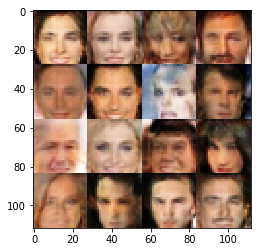

batch 5375 discriminator loss: 1.4512 generator loss: 0.7019


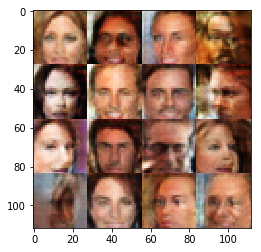

batch 5631 discriminator loss: 1.4447 generator loss: 0.6929


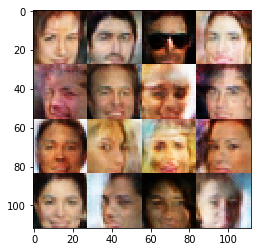

batch 5887 discriminator loss: 1.4880 generator loss: 0.5540


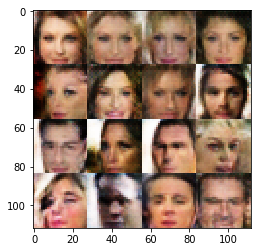

batch 6143 discriminator loss: 1.4759 generator loss: 0.5482


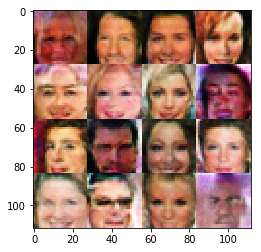

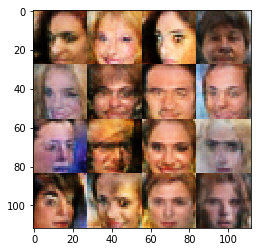

In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.45

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.